<a href="https://colab.research.google.com/github/harshaharod21/Deepfake_detection/blob/main/FCD_Net_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!pip install torch==1.11.0 torchvision==0.12.0
#Remember to update the version of lib as given in paper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 41.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0+cu121
    Uninstalling torch-2.3.0+cu121:
      Successfully uninstalled torch-2.3.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.0+cu121
    Uninstalling torchvision-0.18.0+cu121:
      Successfully uninstalled torchvision-0.18.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.0+cu121 requires torch==2.3.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 1.11.0 which is incompatible.


In [ ]:
#Libraries
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


In [ ]:
import numpy as np
from google.colab import files
import zipfile
import os

In [ ]:


# Upload the zip file
uploaded = files.upload()

# Extract the zip file into a directory
extracted_folder = "extracted_images"
for filename in uploaded.keys():
    with open(filename, 'wb') as f:
        f.write(uploaded[filename])
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)

# Verify the presence of the extracted directory and list its contents
print("List of files and directories in the extracted directory:")
print(os.listdir(extracted_folder))



Saving images1.zip to images1.zip
List of files and directories in the extracted directory:
['image_data']


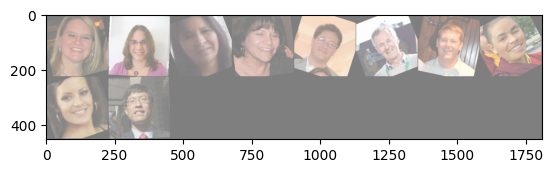

In [ ]:


# Import necessary libraries
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder(root=extracted_folder, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Display a batch of images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
images, labels = next(iter(dataloader))

# Show images
imshow(torchvision.utils.make_grid(images))




In [ ]:
# Assuming `dataset` is your dataset object
sample_data, label = dataset[0]  # Access the first element of the dataset
print("Type of sample_data:", type(sample_data))

Type of sample_data: <class 'torch.Tensor'>


In [ ]:
print("Type of dataset:", type(dataset))


Type of dataset: <class 'torchvision.datasets.folder.ImageFolder'>


## FSS Module

In [ ]:
import torch
import torch.nn as nn

torch.Size([10, 64, 112, 112])


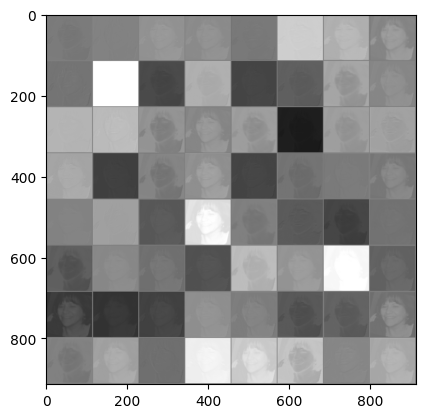

In [ ]:
# @title
# Define the FSS module
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class FSSModule(nn.Module):
    def __init__(self):
        super(FSSModule, self).__init__()

        self.branch1_layer1 = DepthwiseSeparableConv(3, 64, 7, 1, 3)
        self.branch1_layer2 = DepthwiseSeparableConv(64, 64, 5, 2, 2)

        self.branch2_layer1 = DepthwiseSeparableConv(3, 64, 5, 1, 2)
        self.branch2_layer2 = DepthwiseSeparableConv(64, 64, 3, 2, 1)

        self.branch3_layer1 = DepthwiseSeparableConv(3, 64, 3, 1, 1)
        self.branch3_layer2 = DepthwiseSeparableConv(64, 64, 1, 2, 0)

    def forward(self, x):
        branch1 = self.branch1_layer1(x)
        branch1 = self.branch1_layer2(branch1)

        branch2 = self.branch2_layer1(x)
        branch2 = self.branch2_layer2(branch2)

        branch3 = self.branch3_layer1(x)
        branch3 = self.branch3_layer2(branch3)

        out = branch1 + branch2 + branch3
        return out

# Instantiate the FSS module
fss_module = FSSModule()

# Process a batch of images through the FSS module
output = fss_module(images)        #check in channel and out channel as parameters
print(output.shape)  # Expected output shape: torch.Size([32, 64, 112, 112])

# Display the output feature map of the first image in the batch
output_image = output[0].detach().cpu()
imshow(torchvision.utils.make_grid(output_image.unsqueeze(1)))  # Unsqueeze to add channel dimension for display

### Updated code with B and R

torch.Size([10, 64, 112, 112])


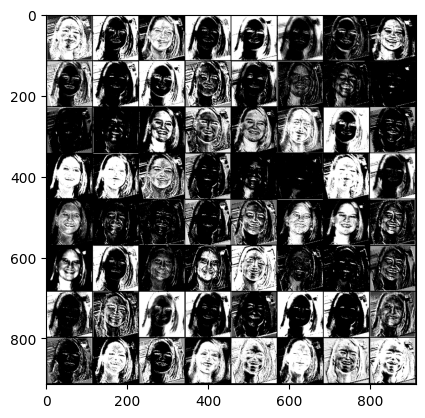

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the Depthwise Separable Convolution block with BatchNorm and optional ReLU
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, apply_relu=True):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.apply_relu = apply_relu
        if self.apply_relu:
            self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.batchnorm(x)
        if self.apply_relu:
            x = self.relu(x)
        return x

class FSSModule(nn.Module):
    def __init__(self):
        super(FSSModule, self).__init__()

        # Branch 1
        self.branch1_layer1 = DepthwiseSeparableConv(3, 64, 7, 1, 3, apply_relu=True)  # DS11
        self.branch1_layer2 = DepthwiseSeparableConv(64, 64, 5, 2, 2, apply_relu=False) # DS22

        # Branch 2
        self.branch2_layer1 = DepthwiseSeparableConv(3, 64, 5, 1, 2, apply_relu=True)  # DS12
        self.branch2_layer2 = DepthwiseSeparableConv(64, 64, 3, 2, 1, apply_relu=False) # DS23

        # Branch 3
        self.branch3_layer1 = DepthwiseSeparableConv(3, 64, 3, 1, 1, apply_relu=True)  # DS13
        self.branch3_layer2 = DepthwiseSeparableConv(64, 64, 1, 2, 0, apply_relu=False) # DS24

        # Final ReLU
        self.final_relu = nn.ReLU()

    def forward(self, x):
        # Branch 1
        branch1 = self.branch1_layer1(x)
        branch1 = self.branch1_layer2(branch1)

        # Branch 2
        branch2 = self.branch2_layer1(x)
        branch2 = self.branch2_layer2(branch2)

        # Branch 3
        branch3 = self.branch3_layer1(x)
        branch3 = self.branch3_layer2(branch3)

        # Sum the branches
        out = branch1 + branch2 + branch3

        # Apply final ReLU
        out = self.final_relu(out)

        return out

# Instantiate the FSS module
fss_module = FSSModule()




# Process a batch of images through the FSS module
output = fss_module(images)
print(output.shape)  # Expected output shape: torch.Size([32, 64, 112, 112])

# Display the output feature map of the first image in the batch
output_image = output[0].detach().cpu()
grid = torchvision.utils.make_grid(output_image.unsqueeze(1))  # Unsqueeze to add channel dimension for display

# Function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(grid)


In [ ]:
output_features = fss_module(images)
print("Output feature shape:", output_features.shape)

single_feature_map = output_features[0]
print("Single feature map shape:", single_feature_map.shape)

Output feature shape: torch.Size([10, 64, 112, 112])
Single feature map shape: torch.Size([64, 112, 112])


### Visualisation of extracted feature map

Note: Might need to compare with standard convolution feature map

In [ ]:
import matplotlib.pyplot as plt

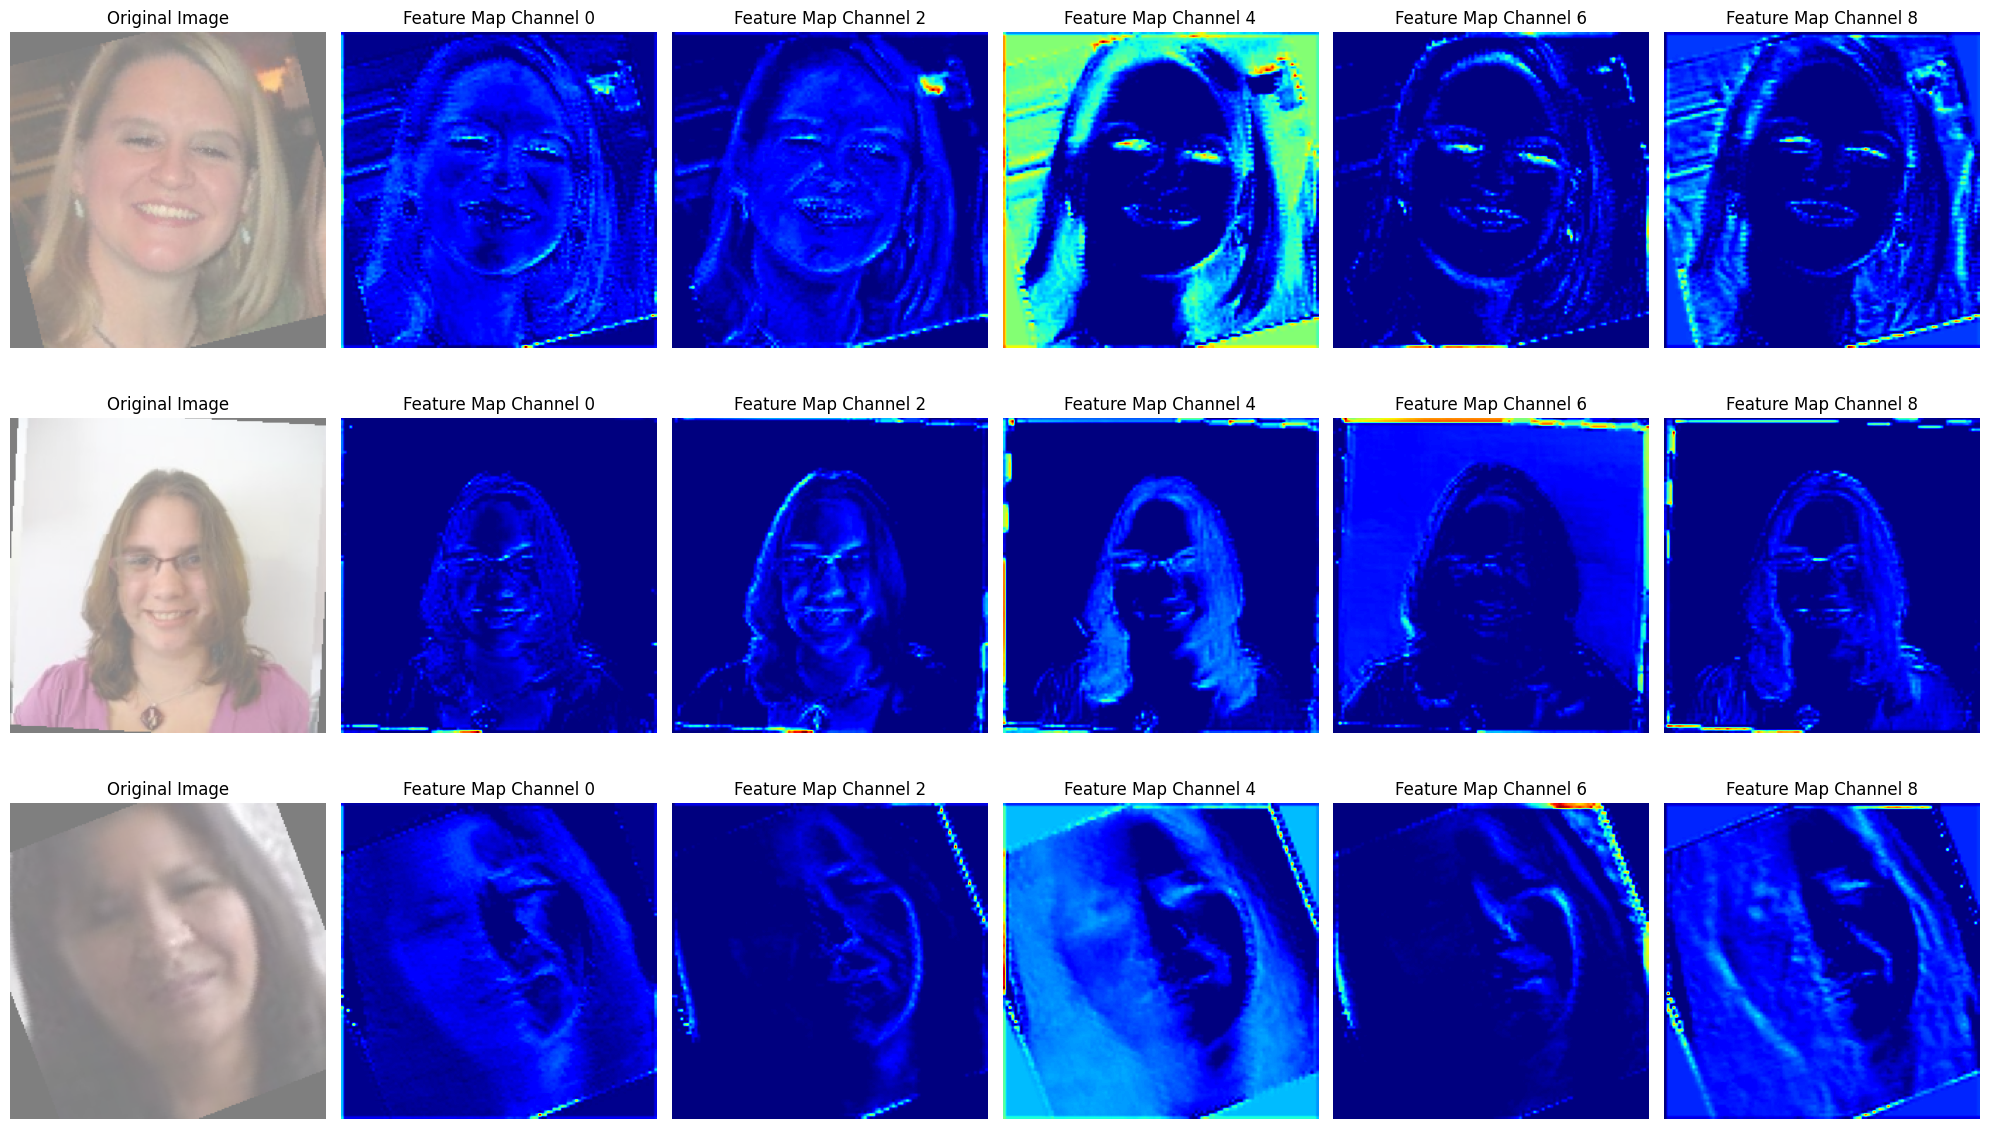

In [ ]:
#visual

# Channels to visualize
channels_to_visualize = [0, 2, 4, 6, 8]

# Plot feature maps for the first three images
fig, axes = plt.subplots(3, len(channels_to_visualize) + 1, figsize=(20, 12))

for i in range(3):  # First three images
    # Display the original image
    original_image = images[i].permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i, 0].imshow(original_image / 2 + 0.5)  # Unnormalize if images are normalized
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')

    # Display specific channels from the feature map
    # Display specific channels from the feature map
    for j, channel in enumerate(channels_to_visualize):
        feature_map = output[i, channel].detach().cpu().numpy()
        axes[i, j + 1].imshow(feature_map, cmap='jet')  # Change colormap here
        axes[i, j + 1].set_title(f"Feature Map Channel {channel}")
        axes[i, j + 1].axis('off')

plt.tight_layout()
plt.show()

## CDFE

In [ ]:
# @title
#the architecture of CDFE

'''
Input
  |
  |---------------------------------
  |                                |
  v                                v
 Ci (1x1 Conv)                     Ci (1x1 Conv)
  |                                |
 DW (3x3 Depthwise Conv)           |
  |                                |
 Ci (1x1 Conv)                     |
  |                                |
 CBAMi                             |
  |                                |
  |                                |
  ----------------------------------
             |
             v
          Output

'''

In [ ]:
# @title
import torch
import torch.nn as nn

# Define CBAM module as before
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(nn.ReLU()(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(nn.ReLU()(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# Updated CD sub-module with the described architecture
class CD(nn.Module):
    def __init__(self, in_channels, out_channels, expansion=6, stride=2):
        super(CD, self).__init__()
        mid_channels = in_channels * expansion

        # Path 1: 1x1 Conv -> 3x3 Depthwise Conv -> 1x1 Conv -> CBAM
        self.path1_conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1)
        self.path1_dw_conv = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, groups=mid_channels)
        self.path1_conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=1)
        self.cbam = CBAM(out_channels)

        # Path 2: Bottleneck 1x1 Conv with stride
        self.bottleneck_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        # Path 1
        residual = self.path1_conv1(x)
        x1 = self.path1_conv1(x)
        x1 = self.path1_dw_conv(x1)
        x1 = self.path1_conv2(x1)
        x1 = self.cbam(x1)

        # Path 2
        x2 = self.bottleneck_conv(x)

        # Combine Path 1 and Path 2
        out = x1 + x2
        return out

# Updated CDFE module with the new CD sub-modules
class CDFE(nn.Module):
    def __init__(self):
        super(CDFE, self).__init__()
        self.cd1 = CD(64, 64, expansion=1, stride=2)

        self.cd2_1 = CD(64, 128, expansion=6, stride=2)
        self.cd2_2 = CD(128, 128, expansion=6, stride=1)
        self.cd2_3 = CD(128, 128, expansion=6, stride=1)

        self.cd3_1 = CD(128, 256, expansion=6, stride=2)
        self.cd3_2 = CD(256, 256, expansion=6, stride=1)
        self.cd3_3 = CD(256, 256, expansion=6, stride=1)

        self.cd4 = CD(256, 512, expansion=6, stride=2)

    def forward(self, x):
        f1 = self.cd1(x)
        print("After CD1:", f1.shape)

        f2 = self.cd2_1(f1)
        f2 = self.cd2_2(f2)
        f2 = self.cd2_3(f2)
        print("After CD2:", f2.shape)

        f3 = self.cd3_1(f2)
        f3 = self.cd3_2(f3)
        f3 = self.cd3_3(f3)
        print("After CD3:", f3.shape)

        f4 = self.cd4(f3)
        print("After CD4:", f4.shape)

        return f4

# Example usage for first three images
# Assuming the input from FSS module is `fss_output` with shape [12, 64, 112, 112]
#fss_output = torch.randn(12, 64, 112, 112)

# Select only the first three images
first_three_images = output[:3]

# Create an instance of the CDFE module
CDFE_module = CDFE()

# Pass the first three images through the CDFE module
cdfe_output = CDFE_module(first_three_images)

print("Final output:", cdfe_output.shape)  # Should print torch.Size([3, 512, 7, 7])


After CD1: torch.Size([3, 64, 56, 56])
After CD2: torch.Size([3, 128, 28, 28])
After CD3: torch.Size([3, 256, 14, 14])
After CD4: torch.Size([3, 512, 7, 7])
Final output: torch.Size([3, 512, 7, 7])


In [ ]:
import torch
import torch.nn as nn

# Define CBAM module as before
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(nn.ReLU()(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(nn.ReLU()(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# Updated CD sub-module with the described architecture
class CD(nn.Module):
    def __init__(self, in_channels, out_channels, expansion=6, stride=2):
        super(CD, self).__init__()
        mid_channels = in_channels * expansion

        # Path 1: 1x1 Conv -> BatchNorm -> ReLU6 -> 3x3 Depthwise Conv -> BatchNorm -> ReLU6 -> 1x1 Conv -> BatchNorm -> CBAM
        self.path1_conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1)
        self.path1_bn1 = nn.BatchNorm2d(mid_channels)
        self.path1_relu1 = nn.ReLU6()
        self.path1_dw_conv = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, groups=mid_channels)
        self.path1_bn2 = nn.BatchNorm2d(mid_channels)
        self.path1_relu2 = nn.ReLU6()
        self.path1_conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=1)
        self.path1_bn3 = nn.BatchNorm2d(out_channels)
        self.cbam = CBAM(out_channels)

        # Path 2: Bottleneck 1x1 Conv with stride
        self.bottleneck_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.bn_after_bottleneck = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # Path 1
        residual = self.path1_conv1(x)
        x1 = self.path1_bn1(residual)
        x1 = self.path1_relu1(x1)
        x1 = self.path1_dw_conv(x1)
        x1 = self.path1_bn2(x1)
        x1 = self.path1_relu2(x1)
        x1 = self.path1_conv2(x1)
        x1 = self.path1_bn3(x1)
        x1 = self.cbam(x1)

        # Path 2
        x2 = self.bottleneck_conv(x)
        x2 = self.bn_after_bottleneck(x2)

        # Combine Path 1 and Path 2
        out = x1 + x2
        out = nn.ReLU6()(out)  # Applying ReLU6 after combining paths
        return out

class CDFE(nn.Module):
    def __init__(self):
        super(CDFE, self).__init__()
        self.cd1 = CD(64, 64, expansion=1, stride=2)

        self.cd2_1 = CD(64, 128, expansion=6, stride=2)
        self.cd2_2 = CD(128, 128, expansion=6, stride=1)
        self.cd2_3 = CD(128, 128, expansion=6, stride=1)

        self.cd3_1 = CD(128, 256, expansion=6, stride=2)
        self.cd3_2 = CD(256, 256, expansion=6, stride=1)
        self.cd3_3 = CD(256, 256, expansion=6, stride=1)

        self.cd4 = CD(256, 512, expansion=6, stride=2)

    def forward(self, x):
        f1 = self.cd1(x)
        print("After CD1:", f1.shape)

        f2 = self.cd2_1(f1)
        f2 = self.cd2_2(f2)
        f2 = self.cd2_3(f2)
        print("After CD2:", f2.shape)

        f3 = self.cd3_1(f2)
        f3 = self.cd3_2(f3)
        f3 = self.cd3_3(f3)
        print("After CD3:", f3.shape)

        f4 = self.cd4(f3)
        print("After CD4:", f4.shape)

        return f4


first_three_images = output[:3]

# Create an instance of the CDFE module
CDFE_module = CDFE()

# Pass the first three images through the CDFE module
cdfe_output = CDFE_module(first_three_images)

print("Final output:", cdfe_output.shape)

After CD1: torch.Size([3, 64, 56, 56])
After CD2: torch.Size([3, 128, 28, 28])
After CD3: torch.Size([3, 256, 14, 14])
After CD4: torch.Size([3, 512, 7, 7])
Final output: torch.Size([3, 512, 7, 7])


### Visualisation

In [ ]:
import matplotlib.pyplot as plt
import torch


# Function to visualize feature maps for specific channels
def visualize_feature_maps(images, output, channels):
    # Plot feature maps for the first three images
    fig, axes = plt.subplots(3, len(channels), figsize=(20, 12))

    for i in range(3):  # First three images
        # Display specific channels from the feature map
        for j, channel in enumerate(channels):
            feature_map = output[i, channel].detach().cpu().numpy()
            feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())  # Normalize
            axes[i, j].imshow(feature_map, cmap='jet')  # Change colormap here
            axes[i, j].set_title(f"Image {i+1}, Channel {channel}")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

visualize_feature_maps(first_three_images, cdfe_output, [0, 2, 4, 6, 8])


## DFF Module

In [ ]:
import torch
import torch.nn as nn

class DFF(nn.Module):
    def __init__(self, in_channels, num_layers=3):
        super(DFF, self).__init__()
        self.num_layers = num_layers
        self.pool_sizes = list(range(1, num_layers + 1))  # Pooling kernel sizes range from 1x1 to num_layers x num_layers
        self.pooling_layers = nn.ModuleList()

        for pool_size in self.pool_sizes:
            self.pooling_layers.append(nn.AdaptiveAvgPool2d((pool_size, pool_size)))

        # Calculate the output size for each pooling layer
        self.pooling_output_sizes = [in_channels * pool_size * pool_size for pool_size in self.pool_sizes]
        self.output_size = in_channels * num_layers * sum(self.pooling_output_sizes)

    def forward(self, x):
        pooled_features = []

        for i, pool_layer in enumerate(self.pooling_layers):
            pooled_feature = pool_layer(x)
            pooled_feature = pooled_feature.view(x.size(0), -1)  # Flatten the tensor
            pooled_features.append(pooled_feature)

        return torch.cat(pooled_features, dim=1)

# Example usage
# Assuming the input feature map F4(x) has shape [batch_size, in_channels, height, width] and in_channels = 512

dff_module = DFF(in_channels=512, num_layers=3)
dff_output = dff_module(cdfe_output)

print("DFF Output shape:", dff_output.shape)  # Expected output shape: [batch_size, 7168] for 3 images


DFF Output shape: torch.Size([3, 7168])
